In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
# import copy
# import math
from pathlib import Path
from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import itertools
# import pixiedust
import random
from torch.utils import data
from itertools import tee
from datetime import datetime

print(torch.__version__)
torch.cuda.is_available()

1.5.0


True

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    LABS_DIR = Path ('/content/gdrive/My Drive/Labs')
except:
    LABS_DIR = Path ('C:/Labs/')

#DATA_DIR = LABS_DIR/'Data'    
DATA_DIR = LABS_DIR/'DataNoDuplicates'    


In [4]:
#### sanity check for the images 
# classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
# for emotion in classes:
#     print("Class =",emotion)
#     !ls $DATA_DIR\VAL\$emotion | wc -l

In [5]:
# Data augmentation and normalization for training
# for validatin we use normalization and resize (for train we also change the angle and size of the images)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Data Loader

In [6]:
BATCH_SIZE = 16
SAMPLE_SIZE = None 

''' The function takes the data loader and a parameter  '''
def create_train_val_slice(image_datasets,sample_size=None,val_same_as_train=False):
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    if not sample_size: # return the whole data set
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                                      shuffle=True, num_workers=0)
                      for x in ['train', 'val']}
        return dataloaders, dataset_sizes
    
    sample_n = {x: random.sample(list(range(dataset_sizes[x])), sample_size)
                for x in ['train', 'val']}

    image_datasets_reduced = {x: torch.utils.data.Subset(image_datasets[x], sample_n[x])
                              for x in ['train', 'val']}
    
    #clone the image_datasets_reduced[train] generator for the val
    if val_same_as_train:
        image_datasets_reduced['val'] = list(image_datasets_reduced['train'])
        image_datasets_reduced['train'] = image_datasets_reduced['val']
        
    dataset_sizes = {x: len(image_datasets_reduced[x]) for x in ['train', 'val']}

    dataloaders_reduced = {x: torch.utils.data.DataLoader(image_datasets_reduced[x], batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=1) for x in ['train', 'val']}
    return dataloaders_reduced, dataset_sizes


image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes

my_data, dataset_sizes =  create_train_val_slice(image_datasets,sample_size=SAMPLE_SIZE,val_same_as_train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

Classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Train image size: 16844
Validation image size: 5296


In [7]:
def freeze_layers_grad(model, total_freeze_layers = 7):
    # Parameters of newly constructed modules have requires_grad=True by default
    layer = 0
    for child in model.children():
        layer += 1
        # freezes layers 1-6 in the total 10 layers of Resnet50
        if layer < total_freeze_layers:
            for param in child.parameters():
                param.requires_grad = False

def get_model():
    model_conv = torchvision.models.resnet18(pretrained=True)
    #model_conv = torchvision.models.resnet50(pretrained=True)
    #model_conv = torchvision.models.resnet101(pretrained=True)

    num_ftrs = model_conv.fc.in_features #probably the feature exctractor
    model_conv.fc = nn.Linear(num_ftrs, len(class_names))
    model_conv = model_conv.to(device)
    return model_conv

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  


# Show sample of the data for review

classes=tensor([0, 0, 3, 0, 5, 3, 0, 0, 4, 3, 2, 0, 3, 3, 5, 4])


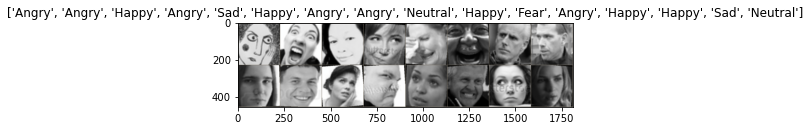

classes=tensor([5, 3, 3, 4, 4, 5, 0, 3, 4, 4, 5, 3, 0, 2, 3, 2])


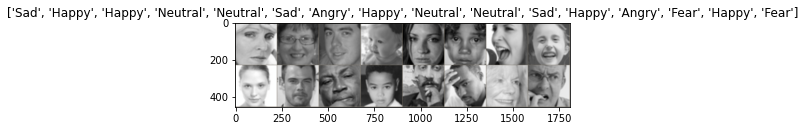

In [9]:
# # Get a batch of training data
inputs, classes = next(iter(my_data['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(my_data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

In [10]:
def train_model(data, model, criterion, optimizer, scheduler, num_epochs=2, writer=None):
    since = time.time()

    train_accuracy_history = []
    train_loss_history = []

    test_accuracy_history = []
    test_loss_history = []

    print("Starting epochs")
    for epoch in range(1,num_epochs+1):
        print(f'Epoch: {epoch} of {num_epochs}')
        model.train()  # Set model to training mode
        running_test_loss = 0.0
        running_corrects = 0.0 
        
        for i, (inputs, labels) in enumerate(data['train']):
            # data['train'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
            
            batch_loss = loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            if writer is not None: # save train loss for each batch
                x_axis = 1000*(epoch + i/(dataset_sizes['train']//BATCH_SIZE))
                writer.add_scalar('batch loss',batch_loss/BATCH_SIZE,x_axis)

        if scheduler is not None:
            scheduler.step() #scheduler step is performed per-epoch in the training phase

        train_acc = running_corrects /dataset_sizes['train']
        if writer is not None: # save epoch accuracy
            x_axis = epoch 
            writer.add_scalar('accuracy-train',
                train_acc,
                x_axis)        
        
        epoch_loss, epoch_acc = eval_model(criterion, data, model, optimizer)
        
        if writer is not None: # save epoch accuracy
            x_axis = epoch 
            writer.add_scalar('accuracy-val',
                epoch_acc,
                x_axis)

    # TODO check stop condition by overfit
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #return the last trained model
    return model


def eval_model(criterion, data, model, optimizer):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0.0

    for i, (inputs, labels) in enumerate(data['val']):
        # data['val'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)


        # statistics - sum loss and accuracy on all batches
        running_loss += loss.item() * inputs.size(0) #item.loss() is the average loss of the batch
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = float(running_loss) / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    print(f'Test Loss: {epoch_loss:.4f} Test Acc: {epoch_acc:.4f}')
                
    return epoch_loss, epoch_acc

In [11]:
#model_conv.eval()

# Train Model

In [12]:
# CHECK_POINT_PATH = LABS_DIR/'ModelParams'/'checkpoint.tar'

# # !del $CHECK_POINT_PATH

# try:
#     checkpoint = torch.load(CHECK_POINT_PATH)
#     print("checkpoint loaded")
# except:
#     checkpoint = None
#     print("checkpoint not found")

In [13]:
# Tensorboard Stuff
NUM_EPOCHS = 30

def run_experiment(data, lr_initial, gamma, step_size, weight_decay, num_of_epochs):
    """
    Gets all hyper parameters and creates the relevant optimizer and scheduler according to those params

    """
    model_net = get_model()
    criterion = nn.CrossEntropyLoss()  # softmax+log
    optimizer = optim.Adam(model_net.parameters(), lr=lr_initial, weight_decay=weight_decay)

    # decay LR by a factor of gamma every step_size epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # check optimizer and schedular due to ADAM

    experiment_name = datetime.now().strftime("%Y%m%d-%H%M%S") + f'_lr_{lr_initial}_st_{step_size}_gma_{gamma}_wDK_{weight_decay}'
    print("Experiment name: ", experiment_name)

    writer = SummaryWriter('runs/' + experiment_name)
    trained_model = train_model(data,
                                model_net,
                                criterion,
                                optimizer,
                                exp_lr_scheduler,
                                num_epochs=num_of_epochs,
                                writer=writer)
    return trained_model


for lr in [0.0005, 0.0001]:
    for scheduler_step_size in [5, 7, 9]:
        for scheduler_gamma in [0.1, 0.3, 0.5]:
            for weight_decay in [0.01,0.1]:
                model_conv = run_experiment(my_data, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS)


Experiment name:  20200630-120649_lr_0.0005_st_5_gma_0.1_wDK_0.01
Starting epochs
Epoch: 1 of 30
Test Loss: 1.6399 Test Acc: 0.3593
Epoch: 2 of 30
Test Loss: 1.4918 Test Acc: 0.4237
Epoch: 3 of 30
Test Loss: 1.4528 Test Acc: 0.4405
Epoch: 4 of 30


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 9633792 bytes. Buy new RAM!


In [ ]:
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

# Test Model

In [ ]:
model_conv.eval()